In [ ]:
a2!pip install pulp

In [1]:
import numpy as np
import pulp

## Prepare Network Map
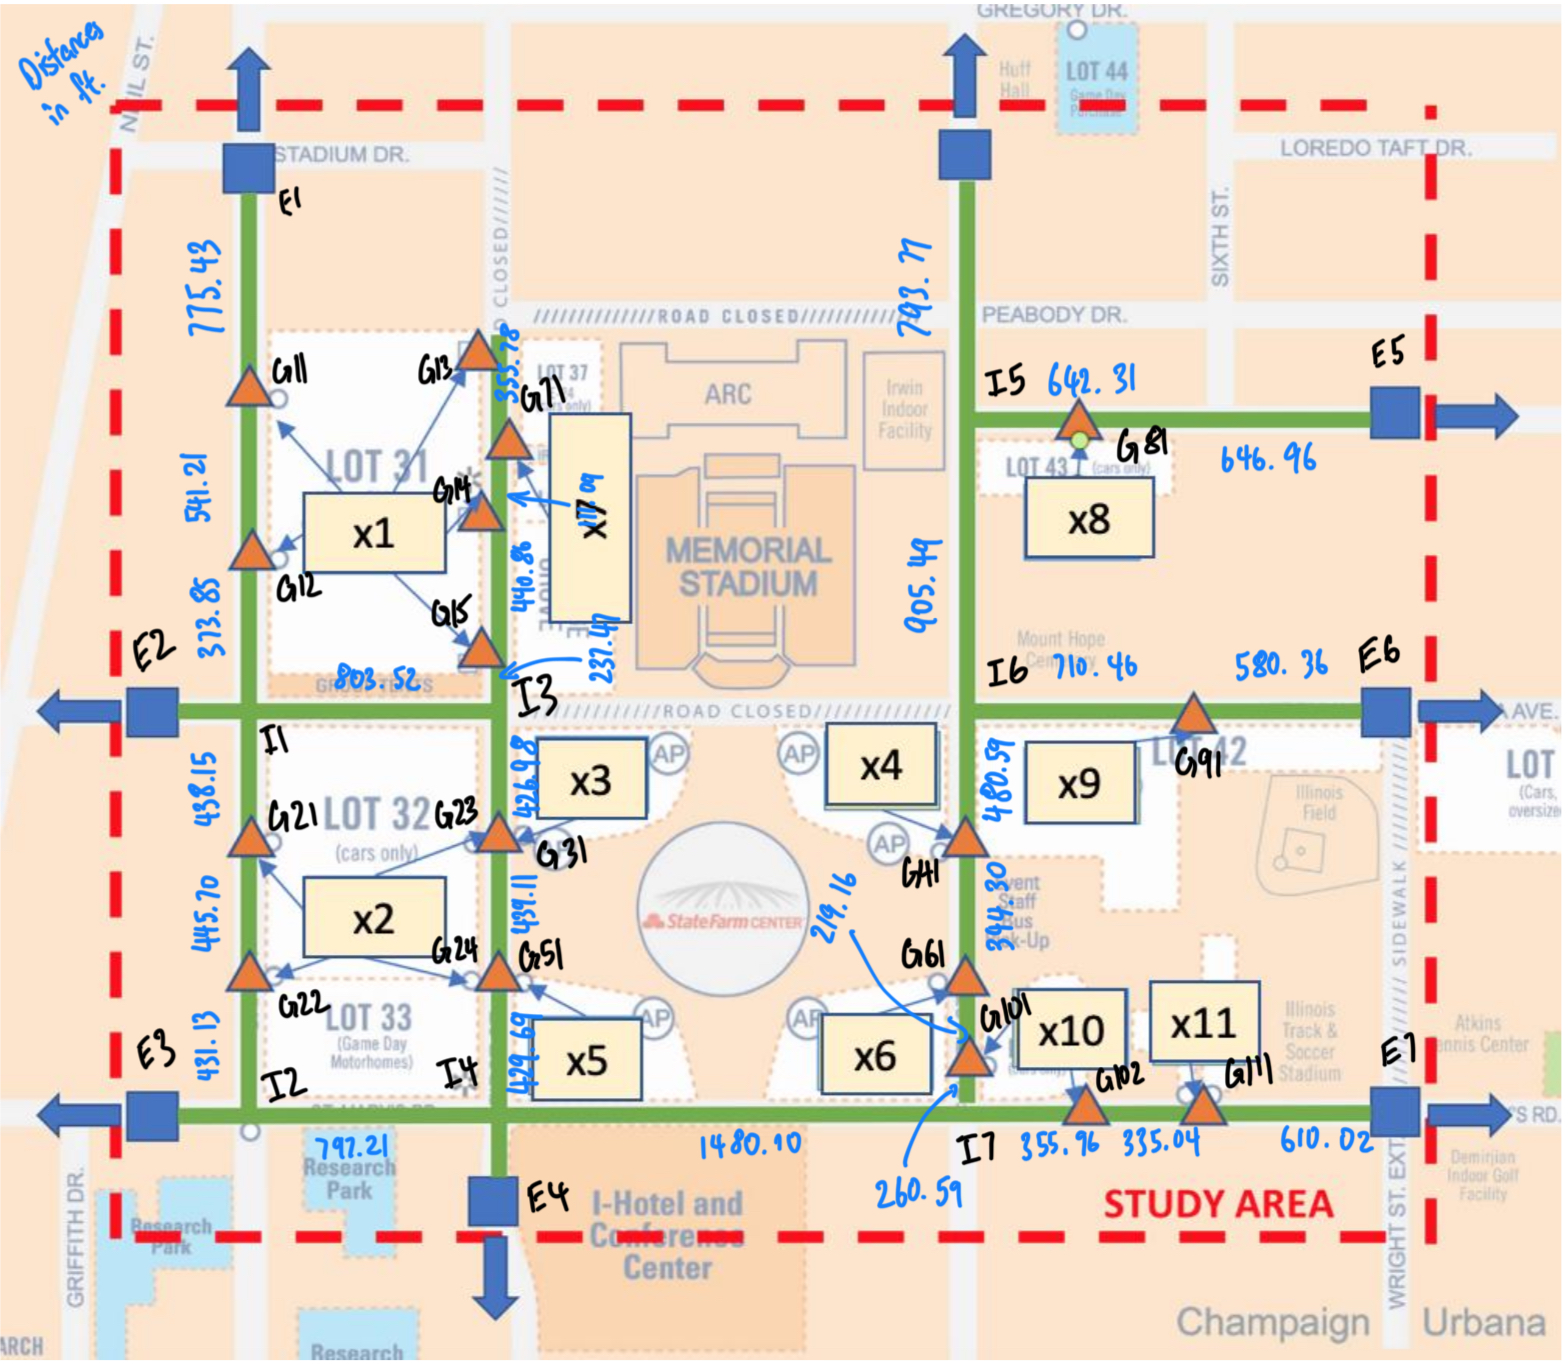

## Task 1A
The following chunk of code models scenario A, where all trips are evenly distributed to each exit. Lines are hashtagged with additional comments.

In [16]:
#Task1A
ncars = np.array([2143, 2473, 434, 526, 501, 437, 776, 221, 601, 0, 152])
#expected number of cars in the parking lots in order x1-x11
tcars = np.sum(ncars)
outflow1a = tcars / 8 #equal distribution among each 8 exits

parkingLots = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11']   #parking lots
exits = ['E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8'] #exits
exitGates = ['G11','G12','G13','G14','G15','G21','G22','G23','G24','G31','G41','G51','G61','G71','G81','G91','G101',
             'G102','G111'] #gij i <- parking lot j <- exit gate number
intersections = ['I1','I2','I3','I4','I5','I6','I7'] #intersection between roads as labeled on the figure
totalNodes = parkingLots + exits + exitGates + intersections #total number of nodes

gatesToLots = { #sets up a dictionary corresponding each exit gate to their respective parking lots
    'x1' : ['G11','G12','G13','G14','G15'],
    'x2' : ['G21','G22','G23','G24'],
    'x3' : ['G31'],
    'x4' : ['G41'],
    'x5' : ['G51'],
    'x6' : ['G61'],
    'x7' : ['G71'],
    'x8' : ['G81'],
    'x9' : ['G91'],
    'x10' : ['G101', 'G102'],
    'x11' : ['G111']
}

links = { #all these values are in ft
    ('G11', 'E1'): 775.43,
    ('G11', 'G12'): 541.21, ('G12', 'G11'): 541.21,
    ('G12', 'I1'): 373.85, ('I1', 'G12'): 373.85,
    ('I1', 'I3'): 803.52, ('I3', 'I1'): 803.52,
    ('G21', 'I1'): 438.15, ('I1', 'G21'): 438.15,
    ('G21', 'G22'): 445.70, ('G22', 'G21'): 445.70,
    ('G22', 'I2'): 431.13, ('I2', 'G22'): 431.13,
    ('I4', 'I2'): 797.21, ('I2', 'I4'): 797.21,
    ('G13', 'G71'): 355.78, ('G71', 'G13'): 355.78,
    ('G71', 'G14'): 111.09, ('G14', 'G71'): 111.09,
    ('G14', 'G15'): 440.80, ('G15', 'G14'): 440.80,
    ('G15', 'I3'): 237.47, ('I3', 'G15'): 237.47,
    ('I3', 'G23'): 426.98, ('G23', 'I3'): 426.98, ('I3', 'G31'): 426.98, ('G31', 'I3'): 426.98,
    ('G23', 'G24'): 439.11, ('G24', 'G23'): 439.11, ('G31', 'G51'): 439.11, ('G51', 'G31'): 439.11,
    ('G24', 'I4') : 429.69, ('I4', 'G24') : 429.69, ('G51', 'I4') : 429.69, ('I4', 'G51') : 429.69,
    ('I4', 'I7') : 1480.90, ('I7', 'I4') : 1480.90,
    ('I5', 'E8') : 793.77,
    ('I5', 'G81') : 642.31, ('G81', 'I5') : 642.31,
    ('G81', 'E5') : 646.96,
    ('I5', 'I6') : 905.49, ('I6', 'I5') : 905.49,
    ('I6', 'G91') : 710.46, ('G91', 'I6') : 710.46,
    ('G91', 'E6') : 580.36,
    ('I6', 'G41') : 480.59, ('G41', 'I6') : 480.59,
    ('G41', 'G61') : 344.30, ('G61', 'G41') : 344.30,
    ('G61', 'G101') : 219.16, ('G101', 'G61') : 219.16,
    ('G101', 'I7') : 260.59, ('I7', 'G101') : 260.59,
    ('I7', 'G102') : 355.96, ('G102', 'I7') : 355.96,
    ('G102', 'G111') : 355.04, ('G111', 'G102') : 355.04,
    ('G111', 'E7') : 610.02,
    ('I1', 'E2') : 700.45,
    ('I2', 'E3') : 693.98,
    ('I4', 'E4') : 327.93 #all the links between nodes with distances based off figure
}

for i in links:
    links[i] /= 5280 #converts all the ft into miles

decisionVariables = {} #sets all the decision variables as links between each nodes as Cij where i is the
                       #start node and j is the finish node
for (i,j) in links:
    decisionVariables[(i,j)] = pulp.LpVariable(f"c{i}{j}", lowBound=0)
    #lowbound so that no links can be less than 0

prob = pulp.LpProblem("MinimizeTotalDistance", pulp.LpMinimize) #establish the minimization problem
prob += pulp.lpSum(decisionVariables[(i,j)] * links[(i,j)] for (i,j) in links)
#adds all the decision variables to the problem for PULP to solve

gateInflow = {g: 0.0 for g in exitGates}
#sets the inflow for all gates as 0 before adding inflows from each parking lot

for xx, lot in enumerate(parkingLots):
#constraint 1: sets the number of cars from each parking lot equal to each # of gates
    gates = gatesToLots.get(lot, [])
    perGate = float(ncars[xx]) / len(gates)
    for g in gates:
        gateInflow[g] += perGate

for node in exitGates + intersections:
#constraint 2: for gates outflow-inflow = source, for intersections outflow = inflow
    inflows = [decisionVariables[(i,j)] for (i,j) in decisionVariables if j == node]
    outflows = [decisionVariables[(i,j)] for (i,j) in decisionVariables if i == node]
    rhs = gateInflow.get(node, 0)  # for gates this is positive; for intersections it's 0
    prob += (pulp.lpSum(outflows) - pulp.lpSum(inflows) == rhs) #outflow = inflow

carsPerExit = float(np.sum(ncars)) / len(exits) #equal distribution of cars per exit

for e in exits: #exit constraint so that each exit receives carsPerExit
    inflows = [decisionVariables[(i,j)] for (i,j) in decisionVariables if j == e]
    prob += (pulp.lpSum(inflows) == carsPerExit)

prob.solve(pulp.PULP_CBC_CMD(msg=0))
print("Status:", pulp.LpStatus[prob.status])
print("Minimum total car-miles:", pulp.value(prob.objective))

nonzero = {k: v.varValue for k, v in decisionVariables.items() if v.varValue > 0}
sortedDescending = sorted(nonzero.items(), key=lambda x: x[1], reverse=True)
#sorts flow of links from highest to lowest
sortedAscending = sorted(nonzero.items(), key=lambda x: x[1])
#sorts flow of links from lowest to highest

print("\nHighest Flow Link:") #this block and block below print out lowest and highest flow links
for (i,j), flow in sortedDescending[:5]:
    print(f"{i} -> {j}: flow = {flow:.0f} cars, dist = {links[(i,j)]:.6f} miles, car-miles = {flow*links[(i,j)]:.6f}")

print("\nLowest Flow Link:")
for (i,j), flow in sortedAscending[:5]:
    print(f"{i} -> {j}: flow = {flow:.0f} cars, dist = {links[(i,j)]:.6f} miles, car-miles = {flow*links[(i,j)]:.6f}")

Status: Optimal
Minimum total car-miles: 3822.2964110795456

Highest Flow Link:
G41 -> I6: flow = 2277 cars, dist = 0.091021 miles, car-miles = 207.254437
I4 -> I7: flow = 2195 cars, dist = 0.280473 miles, car-miles = 615.639299
G15 -> I3: flow = 2062 cars, dist = 0.044975 miles, car-miles = 92.730236
G51 -> I4: flow = 1992 cars, dist = 0.081381 miles, car-miles = 162.069628
I6 -> I5: flow = 1845 cars, dist = 0.171494 miles, car-miles = 316.407017

Lowest Flow Link:
I1 -> G12: flow = 176 cars, dist = 0.070805 miles, car-miles = 12.447506
G21 -> I1: flow = 204 cars, dist = 0.082983 miles, car-miles = 16.887031
G21 -> G22: flow = 415 cars, dist = 0.084413 miles, car-miles = 35.010241
G13 -> G71: flow = 429 cars, dist = 0.067383 miles, car-miles = 28.880172
I6 -> G91: flow = 432 cars, dist = 0.134557 miles, car-miles = 58.128545


## Task 1B
The following chunk of code models scenario B, where trips are weighted so that twice as many cars go to the north and east exits. Lines are hashtagged with additional comments. The majority of this code is copied from task 1A with the main difference being the weighted exits portion.

In [14]:
#Task1B
ncars = np.array([2143, 2473, 434, 526, 501, 437, 776, 221, 601, 0, 152])
#expected number of cars in the parking lots in order x1-x11
tcars = np.sum(ncars)
outflow1a = tcars / 8 #equal distribution among each 8 exits

parkingLots = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11']   #parking lots
exits = ['E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8'] #exits
exitGates = ['G11','G12','G13','G14','G15','G21','G22','G23','G24','G31','G41','G51','G61','G71','G81','G91','G101',
             'G102','G111'] #gij i <- parking lot j <- exit gate number
intersections = ['I1','I2','I3','I4','I5','I6','I7'] #intersection between roads as labeled on the figure
totalNodes = parkingLots + exits + exitGates + intersections #total number of nodes

gatesToLots = { #sets up a dictionary corresponding each exit gate to their respective parking lots
    'x1' : ['G11','G12','G13','G14','G15'],
    'x2' : ['G21','G22','G23','G24'],
    'x3' : ['G31'],
    'x4' : ['G41'],
    'x5' : ['G51'],
    'x6' : ['G61'],
    'x7' : ['G71'],
    'x8' : ['G81'],
    'x9' : ['G91'],
    'x10' : ['G101', 'G102'],
    'x11' : ['G111']
}

links = { #all these values are in ft
    ('G11', 'E1'): 775.43,
    ('G11', 'G12'): 541.21, ('G12', 'G11'): 541.21,
    ('G12', 'I1'): 373.85, ('I1', 'G12'): 373.85,
    ('I1', 'I3'): 803.52, ('I3', 'I1'): 803.52,
    ('G21', 'I1'): 438.15, ('I1', 'G21'): 438.15,
    ('G21', 'G22'): 445.70, ('G22', 'G21'): 445.70,
    ('G22', 'I2'): 431.13, ('I2', 'G22'): 431.13,
    ('I4', 'I2'): 797.21, ('I2', 'I4'): 797.21,
    ('G13', 'G71'): 355.78, ('G71', 'G13'): 355.78,
    ('G71', 'G14'): 111.09, ('G14', 'G71'): 111.09,
    ('G14', 'G15'): 440.80, ('G15', 'G14'): 440.80,
    ('G15', 'I3'): 237.47, ('I3', 'G15'): 237.47,
    ('I3', 'G23'): 426.98, ('G23', 'I3'): 426.98, ('I3', 'G31'): 426.98, ('G31', 'I3'): 426.98,
    ('G23', 'G24'): 439.11, ('G24', 'G23'): 439.11, ('G31', 'G51'): 439.11, ('G51', 'G31'): 439.11,
    ('G24', 'I4') : 429.69, ('I4', 'G24') : 429.69, ('G51', 'I4') : 429.69, ('I4', 'G51') : 429.69,
    ('I4', 'I7') : 1480.90, ('I7', 'I4') : 1480.90,
    ('I5', 'E8') : 793.77,
    ('I5', 'G81') : 642.31, ('G81', 'I5') : 642.31,
    ('G81', 'E5') : 646.96,
    ('I5', 'I6') : 905.49, ('I6', 'I5') : 905.49,
    ('I6', 'G91') : 710.46, ('G91', 'I6') : 710.46,
    ('G91', 'E6') : 580.36,
    ('I6', 'G41') : 480.59, ('G41', 'I6') : 480.59,
    ('G41', 'G61') : 344.30, ('G61', 'G41') : 344.30,
    ('G61', 'G101') : 219.16, ('G101', 'G61') : 219.16,
    ('G101', 'I7') : 260.59, ('I7', 'G101') : 260.59,
    ('I7', 'G102') : 355.96, ('G102', 'I7') : 355.96,
    ('G102', 'G111') : 355.04, ('G111', 'G102') : 355.04,
    ('G111', 'E7') : 610.02,
    ('I1', 'E2') : 700.45,
    ('I2', 'E3') : 693.98,
    ('I4', 'E4') : 327.93 #all the links between nodes with distances based off figure
}

for i in links:
    links[i] /= 5280 #converts all the ft into miles

decisionVariables = {} #sets all the decision variables as links between each nodes as Cij where i is the
                       #start node and j is the finish node
for (i,j) in links:
    decisionVariables[(i,j)] = pulp.LpVariable(f"c{i}{j}", lowBound=0)

prob = pulp.LpProblem("MinimizeTotalDistance", pulp.LpMinimize) #establish the minimization problem
prob += pulp.lpSum(decisionVariables[(i,j)] * links[(i,j)] for (i,j) in links)
#adds all the decision variables to the problem for PULP to solve

gateInflow = {g: 0.0 for g in exitGates}
#sets the inflow for all gates as 0 before adding inflows from each parking lot

for xx, lot in enumerate(parkingLots):
#constraint 1: equalizes the number of cars from each parking lot to each # of gates
    gates = gatesToLots.get(lot, [])
    perGate = float(ncars[xx]) / len(gates)
    for g in gates:
        gateInflow[g] += perGate

for node in exitGates + intersections:
#constraint 2: for gates outflow-inflow = source, for intersections outflow = inflow
    inflows = [decisionVariables[(i,j)] for (i,j) in decisionVariables if j == node]
    outflows = [decisionVariables[(i,j)] for (i,j) in decisionVariables if i == node]
    rhs = gateInflow.get(node, 0)  # for gates this is positive; for intersections it's 0
    prob += (pulp.lpSum(outflows) - pulp.lpSum(inflows) == rhs) #outflow = inflow

exitWeights = {'E1': 2, 'E2': 1, 'E3': 1, 'E4': 1, 'E5': 2, 'E6': 2, 'E7': 2, 'E8': 2}
totalWeight = sum(exitWeights.values())
carsPerExit = {e: tcars * w / totalWeight for e, w in exitWeights.items()}

for e in exits: #exit constraint so that each exit receives carsPerExit
    inflows = [decisionVariables[(i,j)] for (i,j) in decisionVariables if j == e]
    prob += (pulp.lpSum(inflows) == carsPerExit[e])

prob.solve(pulp.PULP_CBC_CMD(msg=0))
print("Status:", pulp.LpStatus[prob.status])
print("Minimum total car-miles:", pulp.value(prob.objective))

nonzero = {k: v.varValue for k, v in decisionVariables.items() if v.varValue > 0}
sortedDescending = sorted(nonzero.items(), key=lambda x: x[1], reverse=True)
#sorts flow of links from highest to lowest
sortedAscending = sorted(nonzero.items(), key=lambda x: x[1]) #sorts flow of links from lowest to highest

print("\nHighest Flow Link:") #this block and block below print out lowest and highest flow links
for (i,j), flow in sortedDescending[:5]:
    print(f"{i} -> {j}: flow = {flow:.0f} cars, dist = {links[(i,j)]:.6f} miles, car-miles = {flow*links[(i,j)]:.6f}")

print("\nLowest Flow Link:")
for (i,j), flow in sortedAscending[:5]:
    print(f"{i} -> {j}: flow = {flow:.0f} cars, dist = {links[(i,j)]:.6f} miles, car-miles = {flow*links[(i,j)]:.6f}")

Status: Optimal
Minimum total car-miles: 4525.745171198297

Highest Flow Link:
I4 -> I7: flow = 3149 cars, dist = 0.280473 miles, car-miles = 883.081565
G41 -> I6: flow = 2992 cars, dist = 0.091021 miles, car-miles = 272.348332
G51 -> I4: flow = 2548 cars, dist = 0.081381 miles, car-miles = 207.336070
G61 -> G41: flow = 2466 cars, dist = 0.065208 miles, car-miles = 160.813779
I6 -> I5: flow = 2322 cars, dist = 0.171494 miles, car-miles = 398.170226

Lowest Flow Link:
G21 -> G22: flow = 17 cars, dist = 0.084413 miles, car-miles = 1.472355
I1 -> G12: flow = 414 cars, dist = 0.070805 miles, car-miles = 29.326311
G13 -> G71: flow = 429 cars, dist = 0.067383 miles, car-miles = 28.880172
I3 -> I1: flow = 449 cars, dist = 0.152182 miles, car-miles = 68.340172
G21 -> I1: flow = 601 cars, dist = 0.082983 miles, car-miles = 49.856797


## Task 1C
The following chunk of code models scenario C, where trips are weighted so that twice as many cars go to the north and east exits and parking lot 40 is open with the same number of cars as lot 43. Lines are hashtagged with additional comments. The majority of this code is copied from task 1B with the main difference being the array 'ncars' being adjusted.

In [9]:
#Task1C; modeled same way as 1B where cars are weighted to go east-north and not equally distributed
ncars = np.array([2143, 2473, 434, 526, 501, 437, 776, 221, 601, 221, 152])
#expected number of cars in the parking lots in order x1-x11; x10 now has same number of cars as x8
tcars = np.sum(ncars)
outflow1a = tcars / 8 #equal distribution among each 8 exits

parkingLots = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11']   #parking lots
exits = ['E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8'] #exits
exitGates = ['G11','G12','G13','G14','G15','G21','G22','G23','G24','G31','G41','G51','G61','G71','G81','G91','G101',
             'G102','G111'] #gij i <- parking lot j <- exit gate number
intersections = ['I1','I2','I3','I4','I5','I6','I7'] #intersection between roads as labeled on the figure
totalNodes = parkingLots + exits + exitGates + intersections #total number of nodes

gatesToLots = { #sets up a dictionary corresponding each exit gate to their respective parking lots
    'x1' : ['G11','G12','G13','G14','G15'],
    'x2' : ['G21','G22','G23','G24'],
    'x3' : ['G31'],
    'x4' : ['G41'],
    'x5' : ['G51'],
    'x6' : ['G61'],
    'x7' : ['G71'],
    'x8' : ['G81'],
    'x9' : ['G91'],
    'x10' : ['G101', 'G102'],
    'x11' : ['G111']
}

links = { #all these values are in ft
    ('G11', 'E1'): 775.43,
    ('G11', 'G12'): 541.21, ('G12', 'G11'): 541.21,
    ('G12', 'I1'): 373.85, ('I1', 'G12'): 373.85,
    ('I1', 'I3'): 803.52, ('I3', 'I1'): 803.52,
    ('G21', 'I1'): 438.15, ('I1', 'G21'): 438.15,
    ('G21', 'G22'): 445.70, ('G22', 'G21'): 445.70,
    ('G22', 'I2'): 431.13, ('I2', 'G22'): 431.13,
    ('I4', 'I2'): 797.21, ('I2', 'I4'): 797.21,
    ('G13', 'G71'): 355.78, ('G71', 'G13'): 355.78,
    ('G71', 'G14'): 111.09, ('G14', 'G71'): 111.09,
    ('G14', 'G15'): 440.80, ('G15', 'G14'): 440.80,
    ('G15', 'I3'): 237.47, ('I3', 'G15'): 237.47,
    ('I3', 'G23'): 426.98, ('G23', 'I3'): 426.98, ('I3', 'G31'): 426.98, ('G31', 'I3'): 426.98,
    ('G23', 'G24'): 439.11, ('G24', 'G23'): 439.11, ('G31', 'G51'): 439.11, ('G51', 'G31'): 439.11,
    ('G24', 'I4') : 429.69, ('I4', 'G24') : 429.69, ('G51', 'I4') : 429.69, ('I4', 'G51') : 429.69,
    ('I4', 'I7') : 1480.90, ('I7', 'I4') : 1480.90,
    ('I5', 'E8') : 793.77,
    ('I5', 'G81') : 642.31, ('G81', 'I5') : 642.31,
    ('G81', 'E5') : 646.96,
    ('I5', 'I6') : 905.49, ('I6', 'I5') : 905.49,
    ('I6', 'G91') : 710.46, ('G91', 'I6') : 710.46,
    ('G91', 'E6') : 580.36,
    ('I6', 'G41') : 480.59, ('G41', 'I6') : 480.59,
    ('G41', 'G61') : 344.30, ('G61', 'G41') : 344.30,
    ('G61', 'G101') : 219.16, ('G101', 'G61') : 219.16,
    ('G101', 'I7') : 260.59, ('I7', 'G101') : 260.59,
    ('I7', 'G102') : 355.96, ('G102', 'I7') : 355.96,
    ('G102', 'G111') : 355.04, ('G111', 'G102') : 355.04,
    ('G111', 'E7') : 610.02,
    ('I1', 'E2') : 700.45,
    ('I2', 'E3') : 693.98,
    ('I4', 'E4') : 327.93 #all the links between nodes with distances based off figure
}

for i in links:
    links[i] /= 5280 #converts all the ft into miles

decisionVariables = {} #sets all the decision variables as links between each nodes as Cij where i is the
                       #start node and j is the finish node
for (i,j) in links:
    decisionVariables[(i,j)] = pulp.LpVariable(f"c{i}{j}", lowBound=0)

prob = pulp.LpProblem("MinimizeTotalDistance", pulp.LpMinimize) #establish the minimization problem
prob += pulp.lpSum(decisionVariables[(i,j)] * links[(i,j)] for (i,j) in links)
#adds all the decision variables to the problem for PULP to solve

gateInflow = {g: 0.0 for g in exitGates}
#sets the inflow for all gates as 0 before adding inflows from each parking lot

for xx, lot in enumerate(parkingLots):
#constraint 1: equalizes the number of cars from each parking lot to each # of gates
    gates = gatesToLots.get(lot, [])
    perGate = float(ncars[xx]) / len(gates)
    for g in gates:
        gateInflow[g] += perGate

for node in exitGates + intersections:
#constraint 2: for gates outflow-inflow = source, for intersections outflow = inflow
    inflows = [decisionVariables[(i,j)] for (i,j) in decisionVariables if j == node]
    outflows = [decisionVariables[(i,j)] for (i,j) in decisionVariables if i == node]
    rhs = gateInflow.get(node, 0)  # for gates this is positive; for intersections it's 0
    prob += (pulp.lpSum(outflows) - pulp.lpSum(inflows) == rhs) #outflow = inflow

exitWeights = {'E1': 2, 'E2': 1, 'E3': 1, 'E4': 1, 'E5': 2, 'E6': 2, 'E7': 2, 'E8': 2}
totalWeight = sum(exitWeights.values())
carsPerExit = {e: tcars * w / totalWeight for e, w in exitWeights.items()}

for e in exits: #exit constraint so that each exit receives carsPerExit
    inflows = [decisionVariables[(i,j)] for (i,j) in decisionVariables if j == e]
    prob += (pulp.lpSum(inflows) == carsPerExit[e])

prob.solve(pulp.PULP_CBC_CMD(msg=0))
print("Status:", pulp.LpStatus[prob.status])
print("Minimum total car-miles:", pulp.value(prob.objective))

nonzero = {k: v.varValue for k, v in decisionVariables.items() if v.varValue > 0}
sortedDescending = sorted(nonzero.items(), key=lambda x: x[1], reverse=True)
#sorts flow of links from highest to lowest
sortedAscending = sorted(nonzero.items(), key=lambda x: x[1]) #sorts flow of links from lowest to highest

print("\nHighest Flow Link:") #this block and block below print out lowest and highest flow links
for (i,j), flow in sortedDescending[:1]:
    print(f"{i} -> {j}: flow = {flow:.0f} cars, dist = {links[(i,j)]:.6f} miles, car-miles = {flow*links[(i,j)]:.6f}")

print("\nLowest Flow Link:")
for (i,j), flow in sortedAscending[:1]:
    print(f"{i} -> {j}: flow = {flow:.0f} cars, dist = {links[(i,j)]:.6f} miles, car-miles = {flow*links[(i,j)]:.6f}")

Status: Optimal
Minimum total car-miles: 4567.602728963446

Highest Flow Link:
G41 -> I6: flow = 3094 cars, dist = 0.091021 miles, car-miles = 281.632457

Lowest Flow Link:
G21 -> G22: flow = 34 cars, dist = 0.084413 miles, car-miles = 2.907374


## Task 1D
The following chunk of code models scenario D, where all trips are evenly distributed to each exit. Lines are hashtagged with additional comments. We manually tested setting each parking lot's number of cars to 0 and comparing the new minimum total car-miles to the value we calculated in scenario A.

In [14]:
#Task1D
ncars = np.array([2143, 0, 434, 526, 501, 437, 776, 221, 601, 0, 152])
#expected number of cars in the parking lots in order x1-x11; replacing random lots with 0 to test which one makes
#biggest difference
tcars = np.sum(ncars) #[2143, 2473, 434, 526, 501, 437, 776, 221, 601, 0, 152]
outflow1a = tcars / 8 #equal distribution among each 8 exits

parkingLots = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11']   #parking lots
exits = ['E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8'] #exits
exitGates = ['G11','G12','G13','G14','G15','G21','G22','G23','G24','G31','G41','G51','G61','G71','G81','G91','G101',
             'G102','G111'] #gij i <- parking lot j <- exit gate number
intersections = ['I1','I2','I3','I4','I5','I6','I7'] #intersection between roads as labeled on the figure
totalNodes = parkingLots + exits + exitGates + intersections #total number of nodes

gatesToLots = { #sets up a dictionary corresponding each exit gate to their respective parking lots
    'x1' : ['G11','G12','G13','G14','G15'],
    'x2' : ['G21','G22','G23','G24'],
    'x3' : ['G31'],
    'x4' : ['G41'],
    'x5' : ['G51'],
    'x6' : ['G61'],
    'x7' : ['G71'],
    'x8' : ['G81'],
    'x9' : ['G91'],
    'x10' : ['G101', 'G102'],
    'x11' : ['G111']
}

links = { #all these values are in ft
    ('G11', 'E1'): 775.43,
    ('G11', 'G12'): 541.21, ('G12', 'G11'): 541.21,
    ('G12', 'I1'): 373.85, ('I1', 'G12'): 373.85,
    ('I1', 'I3'): 803.52, ('I3', 'I1'): 803.52,
    ('G21', 'I1'): 438.15, ('I1', 'G21'): 438.15,
    ('G21', 'G22'): 445.70, ('G22', 'G21'): 445.70,
    ('G22', 'I2'): 431.13, ('I2', 'G22'): 431.13,
    ('I4', 'I2'): 797.21, ('I2', 'I4'): 797.21,
    ('G13', 'G71'): 355.78, ('G71', 'G13'): 355.78,
    ('G71', 'G14'): 111.09, ('G14', 'G71'): 111.09,
    ('G14', 'G15'): 440.80, ('G15', 'G14'): 440.80,
    ('G15', 'I3'): 237.47, ('I3', 'G15'): 237.47,
    ('I3', 'G23'): 426.98, ('G23', 'I3'): 426.98, ('I3', 'G31'): 426.98, ('G31', 'I3'): 426.98,
    ('G23', 'G24'): 439.11, ('G24', 'G23'): 439.11, ('G31', 'G51'): 439.11, ('G51', 'G31'): 439.11,
    ('G24', 'I4') : 429.69, ('I4', 'G24') : 429.69, ('G51', 'I4') : 429.69, ('I4', 'G51') : 429.69,
    ('I4', 'I7') : 1480.90, ('I7', 'I4') : 1480.90,
    ('I5', 'E8') : 793.77,
    ('I5', 'G81') : 642.31, ('G81', 'I5') : 642.31,
    ('G81', 'E5') : 646.96,
    ('I5', 'I6') : 905.49, ('I6', 'I5') : 905.49,
    ('I6', 'G91') : 710.46, ('G91', 'I6') : 710.46,
    ('G91', 'E6') : 580.36,
    ('I6', 'G41') : 480.59, ('G41', 'I6') : 480.59,
    ('G41', 'G61') : 344.30, ('G61', 'G41') : 344.30,
    ('G61', 'G101') : 219.16, ('G101', 'G61') : 219.16,
    ('G101', 'I7') : 260.59, ('I7', 'G101') : 260.59,
    ('I7', 'G102') : 355.96, ('G102', 'I7') : 355.96,
    ('G102', 'G111') : 355.04, ('G111', 'G102') : 355.04,
    ('G111', 'E7') : 610.02,
    ('I1', 'E2') : 700.45,
    ('I2', 'E3') : 693.98,
    ('I4', 'E4') : 327.93 #all the links between nodes with distances based off figure
}

for i in links:
    links[i] /= 5280 #converts all the ft into miles

decisionVariables = {}
#sets all the decision variables as links between each nodes as Cij where i is the start node and j is the finish node
for (i,j) in links:
    decisionVariables[(i,j)] = pulp.LpVariable(f"c{i}{j}", lowBound=0) #lowbound so that no links can be less than 0

prob = pulp.LpProblem("MinimizeTotalDistance", pulp.LpMinimize) #establish the minimization problem
prob += pulp.lpSum(decisionVariables[(i,j)] * links[(i,j)] for (i,j) in links)
#adds all the decision variables to the problem for PULP to solve

gateInflow = {g: 0.0 for g in exitGates}
#sets the inflow for all gates as 0 before adding inflows from each parking lot

for xx, lot in enumerate(parkingLots):
#constraint 1: equalizes the number of cars from each parking lot to each # of gates
    gates = gatesToLots.get(lot, [])
    perGate = float(ncars[xx]) / len(gates)
    for g in gates:
        gateInflow[g] += perGate

for node in exitGates + intersections:
#constraint 2: for gates outflow-inflow = source, for intersections outflow = inflow
    inflows = [decisionVariables[(i,j)] for (i,j) in decisionVariables if j == node]
    outflows = [decisionVariables[(i,j)] for (i,j) in decisionVariables if i == node]
    rhs = gateInflow.get(node, 0)  # for gates this is positive; for intersections it's 0
    prob += (pulp.lpSum(outflows) - pulp.lpSum(inflows) == rhs) #outflow = inflow

carsPerExit = float(np.sum(ncars)) / len(exits) #equal distribution of cars per exit

for e in exits: #exit constraint so that each exit receives carsPerExit
    inflows = [decisionVariables[(i,j)] for (i,j) in decisionVariables if j == e]
    prob += (pulp.lpSum(inflows) == carsPerExit)

prob.solve(pulp.PULP_CBC_CMD(msg=0))
print("Status:", pulp.LpStatus[prob.status])
print("Minimum total car-miles:", pulp.value(prob.objective))
print("Minimum total car-miles (1A): 3822.2964110795456")
#closing down parking lot x2 causes the lowest total car-miles compared to any other parking lot
#this also makes sense because cutting down the biggest parking lot
#means you have less cars in the network trying to leave

nonzero = {k: v.varValue for k, v in decisionVariables.items() if v.varValue > 0}
sortedDescending = sorted(nonzero.items(), key=lambda x: x[1], reverse=True)
#sorts flow of links from highest to lowest
sortedAscending = sorted(nonzero.items(), key=lambda x: x[1]) #sorts flow of links from lowest to highest

print("\nHighest Flow Link:") #this block and block below print out lowest and highest flow links
for (i,j), flow in sortedDescending[:1]:
    print(f"{i} -> {j}: flow = {flow:.0f} cars, dist = {links[(i,j)]:.6f} miles, car-miles = {flow*links[(i,j)]:.6f}")

print("\nLowest Flow Link:")
for (i,j), flow in sortedAscending[:1]:
    print(f"{i} -> {j}: flow = {flow:.0f} cars, dist = {links[(i,j)]:.6f} miles, car-miles = {flow*links[(i,j)]:.6f}")

Status: Optimal
Minimum total car-miles: 2544.1944025568177
Minimum total car-miles (1A): 3822.2964110795456

Highest Flow Link:
G51 -> I4: flow = 2406 cars, dist = 0.081381 miles, car-miles = 195.822266

Lowest Flow Link:
I6 -> G91: flow = 123 cars, dist = 0.134557 miles, car-miles = 16.533669


## Task 2
The following chunk of code models task 2, based off of the code from Task 1A. For this section we increased the trip demand out of parking lot 31 by 20%.

In [17]:
#Task2
ncars = np.array([2143, 2473, 434, 526, 501, 437, 776, 221, 601, 0, 152])
#expected number of cars in the parking lots in order x1-x11
ncars[0] = ncars[0] * 1.2 #increasing parking lot 31's trip demand by 20%
tcars = np.sum(ncars)
outflow1a = tcars / 8 #equal distribution among each 8 exits

parkingLots = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11']   #parking lots
exits = ['E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8'] #exits
exitGates = ['G11','G12','G13','G14','G15','G21','G22','G23','G24','G31','G41','G51','G61','G71','G81','G91',
             'G101','G102','G111'] #gij i <- parking lot j <- exit gate number
intersections = ['I1','I2','I3','I4','I5','I6','I7'] #intersection between roads as labeled on the figure
totalNodes = parkingLots + exits + exitGates + intersections #total number of nodes

gatesToLots = { #sets up a dictionary corresponding each exit gate to their respective parking lots
    'x1' : ['G11','G12','G13','G14','G15'],
    'x2' : ['G21','G22','G23','G24'],
    'x3' : ['G31'],
    'x4' : ['G41'],
    'x5' : ['G51'],
    'x6' : ['G61'],
    'x7' : ['G71'],
    'x8' : ['G81'],
    'x9' : ['G91'],
    'x10' : ['G101', 'G102'],
    'x11' : ['G111']
}

links = { #all these values are in ft
    ('G11', 'E1'): 775.43,
    ('G11', 'G12'): 541.21, ('G12', 'G11'): 541.21,
    ('G12', 'I1'): 373.85, ('I1', 'G12'): 373.85,
    ('I1', 'I3'): 803.52, ('I3', 'I1'): 803.52,
    ('G21', 'I1'): 438.15, ('I1', 'G21'): 438.15,
    ('G21', 'G22'): 445.70, ('G22', 'G21'): 445.70,
    ('G22', 'I2'): 431.13, ('I2', 'G22'): 431.13,
    ('I4', 'I2'): 797.21, ('I2', 'I4'): 797.21,
    ('G13', 'G71'): 355.78, ('G71', 'G13'): 355.78,
    ('G71', 'G14'): 111.09, ('G14', 'G71'): 111.09,
    ('G14', 'G15'): 440.80, ('G15', 'G14'): 440.80,
    ('G15', 'I3'): 237.47, ('I3', 'G15'): 237.47,
    ('I3', 'G23'): 426.98, ('G23', 'I3'): 426.98, ('I3', 'G31'): 426.98, ('G31', 'I3'): 426.98,
    ('G23', 'G24'): 439.11, ('G24', 'G23'): 439.11, ('G31', 'G51'): 439.11, ('G51', 'G31'): 439.11,
    ('G24', 'I4') : 429.69, ('I4', 'G24') : 429.69, ('G51', 'I4') : 429.69, ('I4', 'G51') : 429.69,
    ('I4', 'I7') : 1480.90, ('I7', 'I4') : 1480.90,
    ('I5', 'E8') : 793.77,
    ('I5', 'G81') : 642.31, ('G81', 'I5') : 642.31,
    ('G81', 'E5') : 646.96,
    ('I5', 'I6') : 905.49, ('I6', 'I5') : 905.49,
    ('I6', 'G91') : 710.46, ('G91', 'I6') : 710.46,
    ('G91', 'E6') : 580.36,
    ('I6', 'G41') : 480.59, ('G41', 'I6') : 480.59,
    ('G41', 'G61') : 344.30, ('G61', 'G41') : 344.30,
    ('G61', 'G101') : 219.16, ('G101', 'G61') : 219.16,
    ('G101', 'I7') : 260.59, ('I7', 'G101') : 260.59,
    ('I7', 'G102') : 355.96, ('G102', 'I7') : 355.96,
    ('G102', 'G111') : 355.04, ('G111', 'G102') : 355.04,
    ('G111', 'E7') : 610.02,
    ('I1', 'E2') : 700.45,
    ('I2', 'E3') : 693.98,
    ('I4', 'E4') : 327.93 #all the links between nodes with distances based off figure
}

for i in links:
    links[i] /= 5280 #converts all the ft into miles

decisionVariables = {}
#sets all the decision variables as links between each nodes as Cij where i is the start node
#and j is the finish node
for (i,j) in links:
    decisionVariables[(i,j)] = pulp.LpVariable(f"c{i}{j}", lowBound=0)
    #lowbound so that no links can be less than 0

prob = pulp.LpProblem("MinimizeTotalDistance", pulp.LpMinimize) #establish the minimization problem
prob += pulp.lpSum(decisionVariables[(i,j)] * links[(i,j)] for (i,j) in links)
#adds all the decision variables to the problem for PULP to solve

gateInflow = {g: 0.0 for g in exitGates} #sets the inflow for all gates as 0 before adding inflows from each parking lot

for xx, lot in enumerate(parkingLots):
#constraint 1: equalizes the number of cars from each parking lot to each # of gates
    gates = gatesToLots.get(lot, [])
    perGate = ncars[xx] / len(gates)
    for i in gates:
        gateInflow[i] += perGate

for node in exitGates + intersections:
#constraint 2: for gates outflow-inflow = source, for intersections outflow = inflow
    inflows = [decisionVariables[(i,j)] for (i,j) in decisionVariables if j == node]
    outflows = [decisionVariables[(i,j)] for (i,j) in decisionVariables if i == node]
    rhs = gateInflow.get(node, 0)  # for gates this is positive; for intersections it's 0
    prob += (pulp.lpSum(outflows) - pulp.lpSum(inflows) == rhs) #outflow = inflow

carsPerExit = tcars / len(exits) #equal distribution of cars per exit

for e in exits: #exit constraint so that each exit receives carsPerExit
    inflows = [decisionVariables[(i,j)] for (i,j) in decisionVariables if j == e]
    prob += (pulp.lpSum(inflows) == carsPerExit)

prob.solve(pulp.PULP_CBC_CMD(msg=0))
print("Status:", pulp.LpStatus[prob.status])
print("Minimum total car-miles:", pulp.value(prob.objective))

nonzero = {k: v.varValue for k, v in decisionVariables.items() if v.varValue > 0}
sortedDescending = sorted(nonzero.items(), key=lambda x: x[1], reverse=True)
#sorts flow of links from highest to lowest
sortedAscending = sorted(nonzero.items(), key=lambda x: x[1]) #sorts flow of links from lowest to highest

print("\nHighest Flow Link:") #this block and block below print out lowest and highest flow links
for (i,j), flow in sortedDescending[:1]:
    print(f"{i} -> {j}: flow = {flow:0f} cars, dist = {links[(i,j)]:.6f} miles, car-miles = {flow*links[(i,j)]:.6f}")

print("\nLowest Flow Link:")
for (i,j), flow in sortedAscending[:1]:
    print(f"{i} -> {j}: flow = {flow:.0f} cars, dist = {links[(i,j)]:.6f} miles, car-miles = {flow*links[(i,j)]:.6f}")

Status: Optimal
Minimum total car-miles: 4103.457737405303

Highest Flow Link:
G41 -> I6: flow = 2437.500000 cars, dist = 0.091021 miles, car-miles = 221.863281

Lowest Flow Link:
I1 -> G12: flow = 58 cars, dist = 0.070805 miles, car-miles = 4.113766


## Task 2 Results
The minimum total car-miles now increases by 7.36% due to the additional constraint put on the system. Likewise the highest and lowest flow links change as cars flow through different links in order to satisfy the additional constraint.

## Task 3
Like with Task 2 and Task 1 subtasks, the initial code was copied over to initialize the necessary information.


In [21]:
# Task 3
# Trip demand
import numpy as np
import pulp

ncars = np.array([2143, 2473, 434, 526, 501, 437, 776, 221, 601, 0, 152])

parkingLots = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11']
exits = ['E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8']
exitGates = ['G11','G12','G13','G14','G15',
             'G21','G22','G23','G24',
             'G31','G41','G51','G61','G71',
             'G81','G91','G101','G102','G111']
intersections = ['I1','I2','I3','I4','I5','I6','I7']

gatesToLots = {
    'x1' : ['G11','G12','G13','G14','G15'],
    'x2' : ['G21','G22','G23','G24'],
    'x3' : ['G31'],
    'x4' : ['G41'],
    'x5' : ['G51'],
    'x6' : ['G61'],
    'x7' : ['G71'],
    'x8' : ['G81'],
    'x9' : ['G91'],
    'x10' : ['G101', 'G102'],
    'x11' : ['G111']
}

links = {  # distances in ft, same as Task 2
    ('G11', 'E1'): 775.43,
    ('G11', 'G12'): 541.21, ('G12', 'G11'): 541.21,
    ('G12', 'I1'): 373.85, ('I1', 'G12'): 373.85,
    ('I1', 'I3'): 803.52, ('I3', 'I1'): 803.52,
    ('G21', 'I1'): 438.15, ('I1', 'G21'): 438.15,
    ('G21', 'G22'): 445.70, ('G22', 'G21'): 445.70,
    ('G22', 'I2'): 431.13, ('I2', 'G22'): 431.13,
    ('I4', 'I2'): 797.21, ('I2', 'I4'): 797.21,
    ('G13', 'G71'): 355.78, ('G71', 'G13'): 355.78,
    ('G71', 'G14'): 111.09, ('G14', 'G71'): 111.09,
    ('G14', 'G15'): 440.80, ('G15', 'G14'): 440.80,
    ('G15', 'I3'): 237.47, ('I3', 'G15'): 237.47,
    ('I3', 'G23'): 426.98, ('G23', 'I3'): 426.98,
    ('I3', 'G31'): 426.98, ('G31', 'I3'): 426.98,
    ('G23', 'G24'): 439.11, ('G24', 'G23'): 439.11,
    ('G31', 'G51'): 439.11, ('G51', 'G31'): 439.11,
    ('G24', 'I4') : 429.69, ('I4', 'G24') : 429.69,
    ('G51', 'I4') : 429.69, ('I4', 'G51') : 429.69,
    ('I4', 'I7') : 1480.90, ('I7', 'I4') : 1480.90,
    ('I5', 'E8') : 793.77,
    ('I5', 'G81') : 642.31, ('G81', 'I5') : 642.31,
    ('G81', 'E5') : 646.96,
    ('I5', 'I6') : 905.49, ('I6', 'I5') : 905.49,
    ('I6', 'G91') : 710.46, ('G91', 'I6'): 710.46,
    ('G91', 'E6') : 580.36,
    ('I6', 'G41') : 480.59, ('G41', 'I6') : 480.59,
    ('G41', 'G61') : 344.30, ('G61', 'G41') : 344.30,
    ('G61', 'G101') : 219.16, ('G101', 'G61') : 219.16,
    ('G101', 'I7') : 260.59, ('I7', 'G101') : 260.59,
    ('I7', 'G102') : 355.96, ('G102', 'I7') : 355.96,
    ('G102', 'G111') : 355.04, ('G111', 'G102') : 355.04,
    ('G111', 'E7') : 610.02,
    ('I1', 'E2') : 700.45,
    ('I2', 'E3') : 693.98,
    ('I4', 'E4') : 327.93
}

# Lane capacity constant: Assignment says 450 cars an hour per lane
laneCap30 = 450 * 0.5  # 225 cars per lane per 30 minutes

#number of lanes in each direction
lanes = {
         ('G11', 'E1'): 1,
    ('G11', 'G12'): 1, ('G12', 'G11'): 1,
    ('G12', 'I1'): 1, ('I1', 'G12'): 1,
    ('I1', 'I3'): 2, ('I3', 'I1'): 2,
    ('G21', 'I1'): 2, ('I1', 'G21'): 2,
    ('G21', 'G22'): 2, ('G22', 'G21'): 2,
    ('G22', 'I2'): 2, ('I2', 'G22'): 2,
    ('I4', 'I2'): 2, ('I2', 'I4'): 2,
    ('G13', 'G71'): 1, ('G71', 'G13'): 1,
    ('G71', 'G14'): 1, ('G14', 'G71'): 1,
    ('G14', 'G15'): 1, ('G15', 'G14'): 1,
    ('G15', 'I3'): 1, ('I3', 'G15'): 1,
    ('I3', 'G23'): 1, ('G23', 'I3'): 1,
    ('I3', 'G31'): 1, ('G31', 'I3'): 1,
    ('G23', 'G24'): 1, ('G24', 'G23'): 1,
    ('G31', 'G51'): 1, ('G51', 'G31'): 1,
    ('G24', 'I4'): 1, ('I4', 'G24'): 1,
    ('G51', 'I4'): 1, ('I4', 'G51'): 1,
    ('I4', 'I7'): 2, ('I7', 'I4'): 2,
    ('I5', 'E8'): 1,
    ('I5', 'G81'): 1, ('G81', 'I5'): 1,
    ('G81', 'E5'): 1,
    ('I5', 'I6'): 1, ('I6', 'I5'): 1,
    ('I6', 'G91'): 2, ('G91', 'I6'): 2,
    ('G91', 'E6'): 2,
    ('I6', 'G41'): 1, ('G41', 'I6'): 1,
    ('G41', 'G61'): 1, ('G61', 'G41'): 1,
    ('G61', 'G101'): 1, ('G101', 'G61'): 1,
    ('G101', 'I7'): 1, ('I7', 'G101'): 1,
    ('I7', 'G102'): 1, ('G102', 'I7'): 1,
    ('G102', 'G111'): 1, ('G111', 'G102'): 1,
    ('G111', 'E7'): 1,
    ('I1', 'E2'): 2,
    ('I2', 'E3'): 2,
    ('I4', 'E4'): 1
}
#Creates a dictionary of all the link capacities
link_capacity = {}
for node in links.keys(): # Corrected from link_lengths_ft.keys()
    link_capacity[node] = lanes[node] * laneCap30 # Corrected from lanes_per_link[node]

#Creates a dictionary of all the decision variables (In this case the links).
decision_variables = {}
for (i, j) in links:
    decision_variables[(i, j)] = pulp.LpVariable(f"c{i}{j}", lowBound=0)

#Creates our linear programming problem
prob = pulp.LpProblem("MaximizeOutflow", pulp.LpMaximize)

prob += pulp.lpSum(var for (i, j), var in decision_variables.items() if j in exits)

# Source supply at gates, which is the amount of cars divided by the amount of gates lot has.
gateSupply = {
    'G11': 428.6,
    'G12': 428.6,
    'G13': 428.6,
    'G14': 428.6,
    'G15': 428.6,
    'G21': 618.25,
    'G22': 618.25,
    'G23': 618.25,
    'G24': 618.25,
    'G31': 434.0,
    'G41': 526.0,
    'G51': 501.0,
    'G61': 437.0,
    'G71': 776.0,
    'G81': 221.0,
    'G91': 601.0,
    'G101': 0.0,
    'G102': 0.0,
    'G111': 152.0
}

# Flow conservation:
# At intersections: inflow = outflow
# At gates: outflow - inflow <= supply (can't send more than parked cars)
for node in exitGates + intersections:
    inflows = [var for (i, j), var in decision_variables.items() if j == node]
    outflows = [var for (i, j), var in decision_variables.items() if i == node]

    if node in intersections:
        prob += (pulp.lpSum(inflows) == pulp.lpSum(outflows))
    else:
        prob += (pulp.lpSum(outflows) - pulp.lpSum(inflows) <= gateSupply[node])

# Capacity constraints on each link
for (i, j), var in decision_variables.items():
    prob += var <= link_capacity[(i, j)], f"cap_{i}_{j}"

prob.solve(pulp.PULP_CBC_CMD(msg=0))
print("Max cars exiting in 30 min:", pulp.value(prob.objective))

nonzero = {k: v.varValue for k, v in decision_variables.items() if v.varValue and v.varValue > 0}
sortedDescending = sorted(nonzero.items(), key=lambda x: x[1], reverse=True)
sortedAscending = sorted(nonzero.items(), key=lambda x: x[1])

print("\nHighest Flow Link:")
for (i, j), flow in sortedDescending[:5]:
    print(f"{i} -> {j}: flow = {flow:.0f} cars")

print("\nLowest Flow Link:")
for (i, j), flow in sortedAscending[:3]:
    print(f"{i} -> {j}: flow = {flow:.0f} cars")

Max cars exiting in 30 min: 2471.0

Highest Flow Link:
I3 -> I1: flow = 450 cars
G22 -> I2: flow = 450 cars
G91 -> E6: flow = 450 cars
I1 -> E2: flow = 450 cars
I2 -> E3: flow = 450 cars

Lowest Flow Link:
G101 -> I7: flow = 73 cars
I7 -> G102: flow = 73 cars
G102 -> G111: flow = 73 cars


## Task 4
For task 4 we reused the code from task 3 and adjusted it to account for adding a lane in each direction on the road(link) we felt could most benefit from the additional flow.


In [24]:
#Task 4
import numpy as np
import pulp

ncars = np.array([2143, 2473, 434, 526, 501, 437, 776, 221, 601, 0, 152])

parkingLots = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11']
exits = ['E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8']
exitGates = ['G11','G12','G13','G14','G15',
             'G21','G22','G23','G24',
             'G31','G41','G51','G61','G71',
             'G81','G91','G101','G102','G111']
intersections = ['I1','I2','I3','I4','I5','I6','I7']

gatesToLots = {
    'x1' : ['G11','G12','G13','G14','G15'],
    'x2' : ['G21','G22','G23','G24'],
    'x3' : ['G31'],
    'x4' : ['G41'],
    'x5' : ['G51'],
    'x6' : ['G61'],
    'x7' : ['G71'],
    'x8' : ['G81'],
    'x9' : ['G91'],
    'x10' : ['G101', 'G102'],
    'x11' : ['G111']
}

links = {  # distances in ft, same as Task 2
    ('G11', 'E1'): 775.43,
    ('G11', 'G12'): 541.21, ('G12', 'G11'): 541.21,
    ('G12', 'I1'): 373.85, ('I1', 'G12'): 373.85,
    ('I1', 'I3'): 803.52, ('I3', 'I1'): 803.52,
    ('G21', 'I1'): 438.15, ('I1', 'G21'): 438.15,
    ('G21', 'G22'): 445.70, ('G22', 'G21'): 445.70,
    ('G22', 'I2'): 431.13, ('I2', 'G22'): 431.13,
    ('I4', 'I2'): 797.21, ('I2', 'I4'): 797.21,
    ('G13', 'G71'): 355.78, ('G71', 'G13'): 355.78,
    ('G71', 'G14'): 111.09, ('G14', 'G71'): 111.09,
    ('G14', 'G15'): 440.80, ('G15', 'G14'): 440.80,
    ('G15', 'I3'): 237.47, ('I3', 'G15'): 237.47,
    ('I3', 'G23'): 426.98, ('G23', 'I3'): 426.98,
    ('I3', 'G31'): 426.98, ('G31', 'I3'): 426.98,
    ('G23', 'G24'): 439.11, ('G24', 'G23'): 439.11,
    ('G31', 'G51'): 439.11, ('G51', 'G31'): 439.11,
    ('G24', 'I4') : 429.69, ('I4', 'G24') : 429.69,
    ('G51', 'I4') : 429.69, ('I4', 'G51') : 429.69,
    ('I4', 'I7') : 1480.90, ('I7', 'I4') : 1480.90,
    ('I5', 'E8') : 793.77,
    ('I5', 'G81') : 642.31, ('G81', 'I5') : 642.31,
    ('G81', 'E5') : 646.96,
    ('I5', 'I6') : 905.49, ('I6', 'I5') : 905.49,
    ('I6', 'G91') : 710.46, ('G91', 'I6'): 710.46,
    ('G91', 'E6') : 580.36,
    ('I6', 'G41') : 480.59, ('G41', 'I6') : 480.59,
    ('G41', 'G61') : 344.30, ('G61', 'G41') : 344.30,
    ('G61', 'G101') : 219.16, ('G101', 'G61') : 219.16,
    ('G101', 'I7') : 260.59, ('I7', 'G101') : 260.59,
    ('I7', 'G102') : 355.96, ('G102', 'I7') : 355.96,
    ('G102', 'G111') : 355.04, ('G111', 'G102') : 355.04,
    ('G111', 'E7') : 610.02,
    ('I1', 'E2') : 700.45,
    ('I2', 'E3') : 693.98,
    ('I4', 'E4') : 327.93
}

# Lane capacity constant: Assignment says 450 cars an hour per lane
laneCap30 = 450 * 0.5  # 225 cars per lane per 30 minutes

#number of lanes in each direction
lanes = {
         ('G11', 'E1'): 1,
    ('G11', 'G12'): 1, ('G12', 'G11'): 1,
    ('G12', 'I1'): 1, ('I1', 'G12'): 1,
    ('I1', 'I3'): 2, ('I3', 'I1'): 2,
    ('G21', 'I1'): 2, ('I1', 'G21'): 2,
    ('G21', 'G22'): 2, ('G22', 'G21'): 2,
    ('G22', 'I2'): 2, ('I2', 'G22'): 2,
    ('I4', 'I2'): 2, ('I2', 'I4'): 2,
    ('G13', 'G71'): 1, ('G71', 'G13'): 1,
    ('G71', 'G14'): 1, ('G14', 'G71'): 1,
    ('G14', 'G15'): 1, ('G15', 'G14'): 1,
    ('G15', 'I3'): 1, ('I3', 'G15'): 1,
    ('I3', 'G23'): 1, ('G23', 'I3'): 1,
    ('I3', 'G31'): 1, ('G31', 'I3'): 1,
    ('G23', 'G24'): 1, ('G24', 'G23'): 1,
    ('G31', 'G51'): 1, ('G51', 'G31'): 1,
    ('G24', 'I4'): 1, ('I4', 'G24'): 1,
    ('G51', 'I4'): 1, ('I4', 'G51'): 1,
    ('I4', 'I7'): 2, ('I7', 'I4'): 2,
    ('I5', 'E8'): 1,
    ('I5', 'G81'): 1, ('G81', 'I5'): 1,
    ('G81', 'E5'): 1,
    ('I5', 'I6'): 1, ('I6', 'I5'): 1,
    ('I6', 'G91'): 2, ('G91', 'I6'): 2,
    ('G91', 'E6'): 2,
    ('I6', 'G41'): 1, ('G41', 'I6'): 1,
    ('G41', 'G61'): 1, ('G61', 'G41'): 1,
    ('G61', 'G101'): 1, ('G101', 'G61'): 1,
    ('G101', 'I7'): 1, ('I7', 'G101'): 1,
    ('I7', 'G102'): 1, ('G102', 'I7'): 1,
    ('G102', 'G111'): 1, ('G111', 'G102'): 1,
    ('G111', 'E7'): 1,
    ('I1', 'E2'): 3, #increase to 3 lanes instead of 2
    ('I2', 'E3'): 2,
    ('I4', 'E4'): 1
}
#Creates a dictionary of all the link capacities
link_capacity = {}
for node in links.keys(): # Corrected from link_lengths_ft.keys()
    link_capacity[node] = lanes[node] * laneCap30 # Corrected from lanes_per_link[node]

#Creates a dictionary of all the decision variables (In this case the links).
decision_variables = {}
for (i, j) in links:
    decision_variables[(i, j)] = pulp.LpVariable(f"c{i}{j}", lowBound=0)

#Creates our linear programming problem
prob = pulp.LpProblem("MaximizeOutflow", pulp.LpMaximize)

prob += pulp.lpSum(var for (i, j), var in decision_variables.items() if j in exits)

# Source supply at gates, which is the amount of cars divided by the amount of gates lot has.
gateSupply = {
    'G11': 428.6,
    'G12': 428.6,
    'G13': 428.6,
    'G14': 428.6,
    'G15': 428.6,
    'G21': 618.25,
    'G22': 618.25,
    'G23': 618.25,
    'G24': 618.25,
    'G31': 434.0,
    'G41': 526.0,
    'G51': 501.0,
    'G61': 437.0,
    'G71': 776.0,
    'G81': 221.0,
    'G91': 601.0,
    'G101': 0.0,
    'G102': 0.0,
    'G111': 152.0
}

# Flow conservation:
# At intersections: inflow = outflow
# At gates: outflow - inflow <= supply (can't send more than parked cars)
for node in exitGates + intersections:
    inflows = [var for (i, j), var in decision_variables.items() if j == node]
    outflows = [var for (i, j), var in decision_variables.items() if i == node]

    if node in intersections:
        prob += (pulp.lpSum(inflows) == pulp.lpSum(outflows))
    else:
        prob += (pulp.lpSum(outflows) - pulp.lpSum(inflows) <= gateSupply[node])

# Capacity constraints on each link
for (i, j), var in decision_variables.items():
    prob += var <= link_capacity[(i, j)], f"cap_{i}_{j}"

prob.solve(pulp.PULP_CBC_CMD(msg=0)) #solve LP
print("Max cars exiting in 30 min:", pulp.value(prob.objective)) #print out objective value from LP

nonzero = {k: v.varValue for k, v in decision_variables.items() if v.varValue and v.varValue > 0}
#loops through decision variables dictionary and puts nonzero values into new dictionary `nonzero`
sortedDescending = sorted(nonzero.items(), key=lambda x: x[1], reverse=True)
#sorts values in nonzero in descending order hence `reverse=True`
sortedAscending = sorted(nonzero.items(), key=lambda x: x[1]) #sorts values in nonzero in ascending order

print("\nHighest Flow Link:")
for (i, j), flow in sortedDescending[:5]: #for loop to show highest flow links; top 5 included as they all
                                          #have same value except for the one we added a lane too
    print(f"{i} -> {j}: flow = {flow:.0f} cars")
#print statement to show output also rounds to nearest car since we cannot have decimal values of cars

print("\nLowest Flow Link:")
for (i, j), flow in sortedAscending[:3]:
#for loop to organize lowest flow links; bottom 3 included as they all have the same value
    print(f"{i} -> {j}: flow = {flow:.0f} cars") #same as above for highest flow link

print(f"\nCost of adding one lane to specified link: ${links['I1', 'E2'] * 120:.2f}")
#cost of adding an additional lane; all costs rounded to 2 decimals
print(f"Economic Benefit from additional lane: ${(2696-2471)*4*150:.2f}")
#difference in expected revenue for different values of cars leaving in 30 minutes
print(f"Expected Revenue: ${(2696-2471)*4*150 - links['I1', 'E2'] * 120:.2f}")
#revenue from number of cars exiting in 30 min minus cost of additional lane
print(f"Original benefit: ${2471*4*150:.2f}, New benefit: ${2696*4*140 + ((2696-2471)*4*150 - links['I1', 'E2'] * 120):.2f}")
#original and new benefits as calculated using max number of cars leaving in a 30 minute period
print(f"Difference in revenue after adding additional lane: ${1560706.00-1482600.00:.2f}")
#calculating the difference in benefits and rounding to 2 decimals

Max cars exiting in 30 min: 2696.0

Highest Flow Link:
I1 -> E2: flow = 675 cars
I3 -> I1: flow = 450 cars
G22 -> I2: flow = 450 cars
G91 -> E6: flow = 450 cars
I2 -> E3: flow = 450 cars

Lowest Flow Link:
G101 -> I7: flow = 73 cars
I7 -> G102: flow = 73 cars
G102 -> G111: flow = 73 cars

Cost of adding one lane to specified link: $84054.00
Economic Benefit from additional lane: $135000.00
Expected Revenue: $50946.00
Original benefit: $1482600.00, New benefit: $1560706.00
Difference in revenue after adding additional lane: $78106.00


## Task 4 part 3
For part 3 we added an additional lane to the same link and then recalculated the economic benefits.


In [27]:
#Task 4
import numpy as np
import pulp

ncars = np.array([2143, 2473, 434, 526, 501, 437, 776, 221, 601, 0, 152])

parkingLots = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11']
exits = ['E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8']
exitGates = ['G11','G12','G13','G14','G15',
             'G21','G22','G23','G24',
             'G31','G41','G51','G61','G71',
             'G81','G91','G101','G102','G111']
intersections = ['I1','I2','I3','I4','I5','I6','I7']

gatesToLots = {
    'x1' : ['G11','G12','G13','G14','G15'],
    'x2' : ['G21','G22','G23','G24'],
    'x3' : ['G31'],
    'x4' : ['G41'],
    'x5' : ['G51'],
    'x6' : ['G61'],
    'x7' : ['G71'],
    'x8' : ['G81'],
    'x9' : ['G91'],
    'x10' : ['G101', 'G102'],
    'x11' : ['G111']
}

links = {  # distances in ft, same as Task 2
    ('G11', 'E1'): 775.43,
    ('G11', 'G12'): 541.21, ('G12', 'G11'): 541.21,
    ('G12', 'I1'): 373.85, ('I1', 'G12'): 373.85,
    ('I1', 'I3'): 803.52, ('I3', 'I1'): 803.52,
    ('G21', 'I1'): 438.15, ('I1', 'G21'): 438.15,
    ('G21', 'G22'): 445.70, ('G22', 'G21'): 445.70,
    ('G22', 'I2'): 431.13, ('I2', 'G22'): 431.13,
    ('I4', 'I2'): 797.21, ('I2', 'I4'): 797.21,
    ('G13', 'G71'): 355.78, ('G71', 'G13'): 355.78,
    ('G71', 'G14'): 111.09, ('G14', 'G71'): 111.09,
    ('G14', 'G15'): 440.80, ('G15', 'G14'): 440.80,
    ('G15', 'I3'): 237.47, ('I3', 'G15'): 237.47,
    ('I3', 'G23'): 426.98, ('G23', 'I3'): 426.98,
    ('I3', 'G31'): 426.98, ('G31', 'I3'): 426.98,
    ('G23', 'G24'): 439.11, ('G24', 'G23'): 439.11,
    ('G31', 'G51'): 439.11, ('G51', 'G31'): 439.11,
    ('G24', 'I4') : 429.69, ('I4', 'G24') : 429.69,
    ('G51', 'I4') : 429.69, ('I4', 'G51') : 429.69,
    ('I4', 'I7') : 1480.90, ('I7', 'I4') : 1480.90,
    ('I5', 'E8') : 793.77,
    ('I5', 'G81') : 642.31, ('G81', 'I5') : 642.31,
    ('G81', 'E5') : 646.96,
    ('I5', 'I6') : 905.49, ('I6', 'I5') : 905.49,
    ('I6', 'G91') : 710.46, ('G91', 'I6'): 710.46,
    ('G91', 'E6') : 580.36,
    ('I6', 'G41') : 480.59, ('G41', 'I6') : 480.59,
    ('G41', 'G61') : 344.30, ('G61', 'G41') : 344.30,
    ('G61', 'G101') : 219.16, ('G101', 'G61') : 219.16,
    ('G101', 'I7') : 260.59, ('I7', 'G101') : 260.59,
    ('I7', 'G102') : 355.96, ('G102', 'I7') : 355.96,
    ('G102', 'G111') : 355.04, ('G111', 'G102') : 355.04,
    ('G111', 'E7') : 610.02,
    ('I1', 'E2') : 700.45,
    ('I2', 'E3') : 693.98,
    ('I4', 'E4') : 327.93
}

# Lane capacity constant: Assignment says 450 cars an hour per lane
laneCap30 = 450 * 0.5  # 225 cars per lane per 30 minutes

#number of lanes in each direction
lanes = {
         ('G11', 'E1'): 1,
    ('G11', 'G12'): 1, ('G12', 'G11'): 1,
    ('G12', 'I1'): 1, ('I1', 'G12'): 1,
    ('I1', 'I3'): 2, ('I3', 'I1'): 2,
    ('G21', 'I1'): 2, ('I1', 'G21'): 2,
    ('G21', 'G22'): 2, ('G22', 'G21'): 2,
    ('G22', 'I2'): 2, ('I2', 'G22'): 2,
    ('I4', 'I2'): 2, ('I2', 'I4'): 2,
    ('G13', 'G71'): 1, ('G71', 'G13'): 1,
    ('G71', 'G14'): 1, ('G14', 'G71'): 1,
    ('G14', 'G15'): 1, ('G15', 'G14'): 1,
    ('G15', 'I3'): 1, ('I3', 'G15'): 1,
    ('I3', 'G23'): 1, ('G23', 'I3'): 1,
    ('I3', 'G31'): 1, ('G31', 'I3'): 1,
    ('G23', 'G24'): 1, ('G24', 'G23'): 1,
    ('G31', 'G51'): 1, ('G51', 'G31'): 1,
    ('G24', 'I4'): 1, ('I4', 'G24'): 1,
    ('G51', 'I4'): 1, ('I4', 'G51'): 1,
    ('I4', 'I7'): 2, ('I7', 'I4'): 2,
    ('I5', 'E8'): 1,
    ('I5', 'G81'): 1, ('G81', 'I5'): 1,
    ('G81', 'E5'): 1,
    ('I5', 'I6'): 1, ('I6', 'I5'): 1,
    ('I6', 'G91'): 2, ('G91', 'I6'): 2,
    ('G91', 'E6'): 2,
    ('I6', 'G41'): 1, ('G41', 'I6'): 1,
    ('G41', 'G61'): 1, ('G61', 'G41'): 1,
    ('G61', 'G101'): 1, ('G101', 'G61'): 1,
    ('G101', 'I7'): 1, ('I7', 'G101'): 1,
    ('I7', 'G102'): 1, ('G102', 'I7'): 1,
    ('G102', 'G111'): 1, ('G111', 'G102'): 1,
    ('G111', 'E7'): 1,
    ('I1', 'E2'): 4, #increase to 4 lanes instead of 3 from task 4 parts 1 and 2
    ('I2', 'E3'): 2,
    ('I4', 'E4'): 1
}
#Creates a dictionary of all the link capacities
link_capacity = {}
for node in links.keys(): # Corrected from link_lengths_ft.keys()
    link_capacity[node] = lanes[node] * laneCap30 # Corrected from lanes_per_link[node]

#Creates a dictionary of all the decision variables (In this case the links).
decision_variables = {}
for (i, j) in links:
    decision_variables[(i, j)] = pulp.LpVariable(f"c{i}{j}", lowBound=0)

#Creates our linear programming problem
prob = pulp.LpProblem("MaximizeOutflow", pulp.LpMaximize)

prob += pulp.lpSum(var for (i, j), var in decision_variables.items() if j in exits)

# Source supply at gates, which is the amount of cars divided by the amount of gates lot has.
gateSupply = {
    'G11': 428.6,'G12': 428.6,'G13': 428.6,'G14': 428.6,'G15': 428.6,'G21': 618.25,'G22': 618.25,'G23': 618.25,
    'G24': 618.25,'G31': 434.0,'G41': 526.0,'G51': 501.0,'G61': 437.0,'G71': 776.0,'G81': 221.0,'G91': 601.0,
    'G101': 0.0,'G102': 0.0,'G111': 152.0
}

# Flow conservation:
# At intersections: inflow = outflow
# At gates: outflow - inflow <= supply (can't send more than parked cars)
for node in exitGates + intersections:
    inflows = [var for (i, j), var in decision_variables.items() if j == node]
    outflows = [var for (i, j), var in decision_variables.items() if i == node]

    if node in intersections:
        prob += (pulp.lpSum(inflows) == pulp.lpSum(outflows))
    else:
        prob += (pulp.lpSum(outflows) - pulp.lpSum(inflows) <= gateSupply[node])

# Capacity constraints on each link
for (i, j), var in decision_variables.items():
    prob += var <= link_capacity[(i, j)], f"cap_{i}_{j}"

prob.solve(pulp.PULP_CBC_CMD(msg=0))
print("Max cars exiting in 30 min:", pulp.value(prob.objective))

print(f"\nCost of adding one lane to specified link: ${links['I1', 'E2'] * 2 * 120:.2f}")
print(f"Economic Benefit from additional lane: ${(2921-2696)*4*150:.2f}")
print(f"Expected Revenue: ${(2696-2471)*4*150 - links['I1', 'E2'] * 2 * 120:.2f}")

Max cars exiting in 30 min: 2921.0

Cost of adding one lane to specified link: $168108.00
Economic Benefit from additional lane: $135000.00
Expected Revenue: $-33108.00
